In [4]:
import os
import math
import shutil
import numpy as np
import pandas as pd
from math import floor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, GRU, TimeDistributed, BatchNormalization, Rescaling
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorcross


In [2]:
#!pip install tensorcross
#!pip install TensorFlow==2.13

In [3]:
#print(tf.__version__)

# CRNN Model

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

## Define Model

In [5]:
import keras.backend as K

def macro_f1_score(y_true, y_pred):
    """
    Calculate macro-average F1 score using Keras backend.

    Parameters:
        y_true (tensor or array): The true class labels (ground truth) as a tensor or Numpy array.
        y_pred (tensor or array): The predicted class labels as a tensor or Numpy array.

    Returns:
        float: The macro-average F1 score.
    """
    # Convert Numpy arrays to Keras backend tensors
    if not tf.is_tensor(y_true):
        y_true = K.constant(y_true)

    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    
    # Calculate true positives, false positives, and false negatives for each class
    tp = K.sum(y_true * K.round(y_pred), axis=0)
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)

    # Calculate precision and recall for each class
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calculate macro-average F1 score
    macro_f1 = K.mean(f1_score)

    return macro_f1

In [5]:
# Defines function for model artitecture:

def create_model(n_filters, kernel_sizes, pool_sizes, GRU_units, dropout_rate, learning_rate, epochs, batch_size): # 8 Hyperparameters
    # Define the input shape
    input_shape = (235, 352, 3)

    # Define the CRNN architecture
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=input_shape))

    # Conv Block 1
    model.add(Conv2D(filters=n_filters[0], kernel_size=kernel_sizes, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Conv Block 2
    model.add(Conv2D(filters=n_filters[1], kernel_size=kernel_sizes, activation="relu"))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Conv Block 3
    model.add(Conv2D(filters=n_filters[2], kernel_size=kernel_sizes, activation="relu"))
    model.add(MaxPool2D(pool_size=pool_sizes))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Recurrent layers
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(GRU_units*2, return_sequences=True))
    model.add(GRU(GRU_units))
    
    # Fully connected layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout_rate))
    num_classes = 8
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy", tf.keras.metrics.F1Score(average = "macro")]
                 )
    return model

In [7]:
model = create_model(n_filters = (64, 128, 256),
                     kernel_sizes = (4,4),
                     pool_sizes = (3,3),
                     GRU_units = 64,
                     dropout_rate = 0.1,
                     learning_rate = 0.001,
                     epochs = 32,
                     batch_size = 64)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 235, 352, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 232, 349, 16)      784       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 116, 174, 16)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 116, 174, 16)      0         
                                                                 
 batch_normalization_3 (Bat  (None, 116, 174, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 113, 171, 32)     

## Create Dataset

In [43]:
batch_size = 64

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
trainingData = tf.keras.utils.image_dataset_from_directory(
    directory = "SpectrogramData_Formatted/training",
    labels="inferred",
    label_mode = "categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(235, 352),
    shuffle=True,
    seed=42
)
print()

# Construct dataset for best model, making a seperate dataset since I need a random split of validation here.
bestTrainingData = tf.keras.utils.image_dataset_from_directory(
    directory = "SpectrogramData_Formatted/training",
    labels="inferred",
    label_mode = "categorical",
    color_mode="rgb",
    validation_split=0.2,
    subset="both",
    batch_size=batch_size,
    image_size=(235, 352),
    shuffle=True,
    seed=42
)


Found 7115 files belonging to 8 classes.

Found 7115 files belonging to 8 classes.
Using 5692 files for training.
Using 1423 files for validation.


## Training

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

from tensorcross.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "n_filters": [(16,32,64)],
    "kernel_sizes": [(3,3)],
    "pool_sizes": [(2,2)],
    "GRU_units": [8],
    "dropout_rate": [0.1],
    "learning_rate": [0.0001],
    "epochs": [1, 2],
    "batch_size": [64]
}

grid_search_cv = GridSearchCV(model_fn = create_model,
                          param_grid = param_grid,
                          n_folds = 2,
                          verbose = 1)

grid_search_cv.fit(dataset = trainingData, verbose = 1)

best_params_ = grid_search_cv.results_["best_params"]

# Retraining best model
# Create the model with the current parameter values
bestModelArchitecture = create_model(n_filters = best_params_["n_filters"],
                     kernel_sizes = best_params_["kernel_sizes"],
                     pool_sizes = best_params_["pool_sizes"],
                     GRU_units = best_params_["GRU_units"],
                     dropout_rate = best_params_["dropout_rate"],
                     learning_rate = best_params_["learning_rate"],
                     epochs = best_params_["epochs"],
                     batch_size = best_params_["batch_size"])

# Train and evaluate the model
bestModel = bestModelArchitecture.fit(bestTrainingData[0], validation_data = bestTrainingData[1], epochs=epochs, verbose=2)
    
bestModelArchitecture.save("best_model_baseline.h5")

Running Comb: 0
Running Fold: 0
56/56 [==============================] - 184s 3s/step - loss: 2.0609 - accuracy: 0.1541 - f1_score: 0.1184 - val_loss: 2.1298 - val_accuracy: 0.1325 - val_f1_score: 0.0363
Running Fold: 1
56/56 [==============================] - 165s 3s/step - loss: 2.0806 - accuracy: 0.1275 - f1_score: 0.1063 - val_loss: 2.0739 - val_accuracy: 0.1439 - val_f1_score: 0.0911
Running Comb: 1
Running Fold: 0
56/56 [==============================] - 155s 3s/step - loss: 2.0665 - accuracy: 0.1498 - f1_score: 0.1030 - val_loss: 2.0870 - val_accuracy: 0.1230 - val_f1_score: 0.0370
Running Fold: 1
56/56 [==============================] - 161s 3s/step - loss: 2.0676 - accuracy: 0.1585 - f1_score: 0.1237 - val_loss: 2.0896 - val_accuracy: 0.1181 - val_f1_score: 0.0264
89/89 - 222s - loss: 2.0576 - accuracy: 0.1803 - f1_score: 0.1355 - val_loss: 2.0397 - val_accuracy: 0.1862 - val_f1_score: 0.1089 - 222s/epoch - 2s/step


In [2]:
best_params_ = grid_search_cv.results_["best_params"]
best_params_


NameError: name 'grid_search_cv' is not defined

In [41]:
bestModel.history

{'loss': [2.057631254196167],
 'accuracy': [0.18025298416614532],
 'f1_score': [0.13547660410404205],
 'val_loss': [2.0396718978881836],
 'val_accuracy': [0.1862262785434723],
 'val_f1_score': [0.10890208184719086]}

In [42]:
bestModelArchitecture.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 233, 350, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 116, 175, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_88 (Dropout)        (None, 116, 175, 16)      0         
                                                                 
 batch_normalization_66 (Ba  (None, 116, 175, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_67 (Conv2D)          (None, 114, 173, 32)      4640      
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 57, 86, 32)      

In [44]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

# Evaluate the model on the test set
testData = tf.keras.utils.image_dataset_from_directory(
    directory = "SpectrogramData_Formatted/test",
    labels="inferred",
    label_mode = "categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(235, 352),
    shuffle=True,
    seed=42
)


test_loss, test_accuracy, test_f1_score = bestModelArchitecture.evaluate(testData)

# Print the best parameters and accuracy
print()
print("Test Accuracy:", test_accuracy)
print("Test f1_score", test_f1_score)
print("Test Loss", test_loss)


Found 789 files belonging to 8 classes.
13/13 [==============================] - 8s 499ms/step - loss: 2.0585 - accuracy: 0.1952 - f1_score: 0.1150

Test Accuracy: 0.19518378376960754
Test f1_score 0.1149878203868866
Test Loss 2.0585107803344727


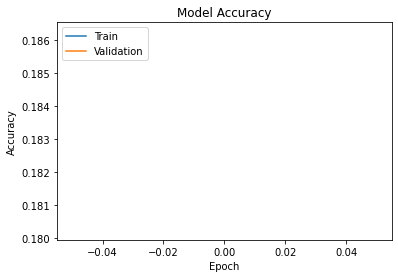

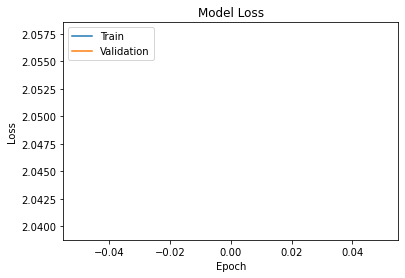

In [45]:
# https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(bestModel.history["accuracy"])
plt.plot(bestModel.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# summarize history for loss
plt.plot(bestModel.history["loss"])
plt.plot(bestModel.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()